In [2]:
import sys, os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from astropy.table import Table, join, hstack, vstack
import pywt
import h5py
sys.path.insert(1, '/home/luiz/IC/Codes/GMCA/gmca4im-master/scripts/')
import gmca4im_lib2 as g4i
from scipy import signal
from sklearn.decomposition import FastICA, PCA
import Extension4BINGO as cs

In [3]:
######## Funções adicionais
######################################################################################################
######## Função para colocar média 0 nos mapas, retorna uma variavel igual ao input
def Remove_mean(map_= None):
    len_nu_ch = np.shape(map_)[0]
    map_ = np.array([[map_[i] - np.mean(map_[i],axis=0)] for i in range(len_nu_ch)])
    return map_[ : , 0, : ]
######################################################################################################

######################################################################################################
####### Tangente hiperbolica como funcão parâmetro G que aproxima a neg-entropy, retorna W
def tanh(x):
    return np.tanh(x), (1/((np.cosh(x))**2)).mean(axis=-1)
######################################################################################################

######################################################################################################
######## Faz a penrose moore inverse com a matriz mistura e os mapas X
def Filter(Ae=None, FG=False):
    W   = np.linalg.inv(np.dot(Ae.T,Ae))
    W   = np.dot(W,Ae.T) #Filter  
    if FG:
        return np.dot(Ae,W) #foreground filter
    else:
        return W
######################################################################################################

######################################################################################################
######## Constroi uma variavel que recebe um mapa e a matriz mistura A, e retorna os mapas separados em 21 e fg
def Reconstruction_maps(X=None,Ae=None):
    X_fg = np.dot(Filter(Ae=Ae,FG=True),X)
    X_21 = X - X_fg
    return {"21cm":X_21,"foregrounds":X_fg}
######################################################################################################

######################################################################################################
######## Constroi uma função que retorna os residos separados em 21 e fg
def Residual_maps(X=None,Ae=None):
    X    = Reconstruction_maps(X,Ae)
    W_fg = Filter(Ae,True)
    R_21 = X["21cm"]        - np.dot(W_fg,X["21cm"])  
    R_fg = X["foregrounds"] - np.dot(W_fg,X["foregrounds"])  
    return {"21cm":R_21, "foregrounds":R_fg}
######################################################################################################

######################################################################################################
########
def Include_scalar_coefs(w,c,J=3):
    nbins,npix = c.shape

    for i in range(nbins):
        X = w[i].reshape(-1,J).T
        X = np.vstack((X,c[i]))
        X = X.T.flatten()
        if i==0:
            Xw_ = np.array(X)
        else:
            Xw_ = np.vstack((Xw_,X))
    return Xw_
######################################################################################################

In [4]:
######## fastICA com wavelets
NSIDE = 2**8
######################################################################################################
######## Leitura dos arquivos
file_21cm = '/home/luiz/IC/Datas_Maps/Cube_21_L100_Smooth.fits' #Arquivo só com 21cm
with fits.open(file_21cm) as hdul1: 
    input_21cm = hdul1[0].data

file_mapas ='/home/luiz/IC/Datas_Maps/Cube_5PSM_L100_RS.fits' #Arquivo com tudo, foregrounds+21cm
with fits.open(file_mapas) as hdul2: 
    X = hdul2[0].data
######################################################################################################

coef1, coef2 = g4i.wavelet_transform(X, J=3) #Transformada wavelet dos mapas
Xw_ = Include_scalar_coefs(coef1,coef2,J=3)


Wavelet transforming the data . . .
. . completed in 9.31 minutes



/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a reg

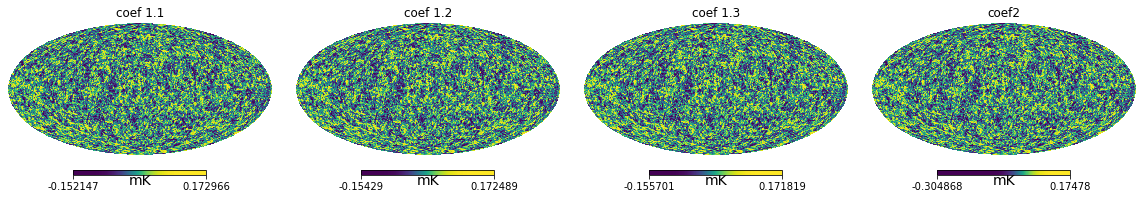

<Figure size 432x288 with 0 Axes>

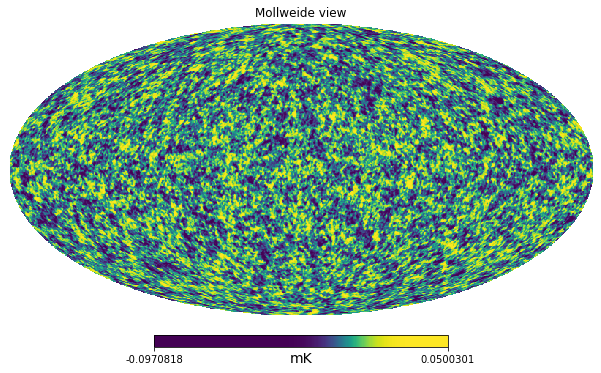

In [5]:
X0 = cs.reshape_coefs(Xw=Xw_, J=3, ndiv=4, idiv=0, use_scale_coefs=True)
X1 = cs.reshape_coefs(Xw=Xw_, J=3, ndiv=4, idiv=1, use_scale_coefs=True)
X2 = cs.reshape_coefs(Xw=Xw_, J=3, ndiv=4, idiv=2, use_scale_coefs=True)
X3 = cs.reshape_coefs(Xw=Xw_, J=3, ndiv=4, idiv=3, use_scale_coefs=True)
ica = FastICA(n_components=5)
Se = ica.fit_transform(X0.T) 
Ae_0 = ica.mixing_  # Get estimated mixing matrix
ica = FastICA(n_components=5)
Se = ica.fit_transform(X1.T) 
Ae_1 = ica.mixing_  # Get estimated mixing matrix
ica = FastICA(n_components=5)
Se = ica.fit_transform(X2.T) 
Ae_2 = ica.mixing_  # Get estimated mixing matrix
ica = FastICA(n_components=5)
Se = ica.fit_transform(X3.T) 
Ae_3 = ica.mixing_  # Get estimated mixing matrix
X_rec0 = Reconstruction_maps(X, Ae_0)
X_rec1 = Reconstruction_maps(X, Ae_1)
X_rec2 = Reconstruction_maps(X, Ae_2)
X_rec3 = Reconstruction_maps(X, Ae_3)
mapas=[X_rec0['21cm'][13], X_rec1['21cm'][13], X_rec2['21cm'][13], X_rec3['21cm'][13]] #vetor com os mapas
titulos=["coef 1.1", "coef 1.2", "coef 1.3", "coef2"] #vetor com os nomes
plt.figure(figsize = (16,4))
for i in range(4):
        hp.mollview(mapas[i],sub = (1,4,i+1), norm='hist', title = titulos[i], nest=False, unit='mK' )

plt.figure()
hp.mollview(0.25*(X_rec0['21cm'][13]+ X_rec1['21cm'][13]+X_rec2['21cm'][13]+ X_rec3['21cm'][13])- input_21cm[13] , norm='hist', nest=False, unit='mK' )

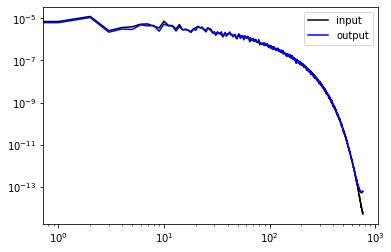

In [6]:
######################################################################################################
######## Cl's
cl_input = hp.anafast(input_21cm[13])
cl_output = hp.anafast(0.25*(X_rec0['21cm'][13]+ X_rec1['21cm'][13]+X_rec2['21cm'][13]+ X_rec3['21cm'][13]))
######################################################################################################

######################################################################################################
######## Comparação do espectro de potência do mapa 21cm com o 21cm reconstruido
plt.figure()
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.legend()
######################################################################################################

In [7]:
######################################################################################################
######## Erro 
print('variância (rec-input):         ',np.var(0.25*(X_rec0['21cm'][13]+ X_rec1['21cm'][13]+X_rec2['21cm'][13]+ X_rec3['21cm'][13])-input_21cm[13]))
print('100*variância (rec-input)/input:         ',100*np.var(0.25*(X_rec0['21cm'][13]+ X_rec1['21cm'][13]+X_rec2['21cm'][13]+ X_rec3['21cm'][13])- input_21cm[13]/(input_21cm[13])))
######################################################################################################

variância (rec-input):          0.00012006649544577359
100*variância (rec-input)/input:          0.1469358080509562
